# CartPole Skating
**Problem**: If Peter wants to escape from the wolf, he needs to be able to move faster than him. We will see how Peter can learn to skate, in particular, to keep balance, using Q-Learning.

First, let's install the gym and import required libraries:

In [4]:
import sys
#!{sys.executable} -m pip install gymnasium[classic-control]

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import random

# Create a cartpole environment
Each environment is associated with an:

- Observation space that defines the structure of information that we receive from the environment. For cartpole problem, we receive position of the pole, velocity and some other values.

- Action space that defines possible actions. In our case the action space is discrete, and consists of two actions - left and right.

In [5]:
env = gym.make("CartPole-v1", render_mode = "human")
print(env.action_space)
print(env.observation_space)
print(env.action_space.sample())

Discrete(2)
Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
0


To see how the environment works, let's run a short simulation for 100 steps. At each step, we provide one of the actions to be taken - in this simulation we just randomly select an action from action_space.

In [6]:
env = gym.make("CartPole-v1", render_mode = "human")
observation, info = env.reset()

for _ in range(100):
    action = env.action_space.sample()  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
       observation, info = env.reset()

env.close()

During simulation, we need to get observations in order to decide how to act. In fact, step function returns us back current observations, reward function, and the done flag that indicates whether it makes sense to continue the simulation or not:


In [7]:
env = gym.make("CartPole-v1", render_mode = "human")
observation, info = env.reset()
terminated = False
truncated = False
while not terminated and not truncated:
    action = env.action_space.sample()  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action)
    print(f"{observation} -> {reward}")

   
env.close()

[-0.02693008 -0.22730981 -0.03385121  0.23465666] -> 1.0
[-0.03147628 -0.03172096 -0.02915807 -0.06850888] -> 1.0
[-0.0321107   0.16380663 -0.03052825 -0.37024686] -> 1.0
[-0.02883457 -0.03086858 -0.03793319 -0.08734401] -> 1.0
[-0.02945194  0.164776   -0.03968007 -0.39174944] -> 1.0
[-0.02615642  0.36043796 -0.04751506 -0.6966742 ] -> 1.0
[-0.01894766  0.5561855  -0.06144854 -1.0039283 ] -> 1.0
[-0.00782395  0.75207204 -0.08152711 -1.3152581 ] -> 1.0
[ 0.00721749  0.9481255  -0.10783227 -1.6323038 ] -> 1.0
[ 0.02618     1.1443359  -0.14047834 -1.9565513 ] -> 1.0
[ 0.04906672  0.9509567  -0.17960937 -1.7105049 ] -> 1.0
[ 0.06808586  1.1476302  -0.21381947 -2.0532913 ] -> 1.0


The observation vector that is returned at each step of the simulation contains the following values:

- Position of cart
- Velocity of cart
- Angle of pole
- Rotation rate of pole
We can get min and max value of those numbers:

In [8]:
print(env.observation_space.low)
print(env.observation_space.high)

[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]


You may also notice that reward value on each simulation step is always 1. This is because our goal is to survive as long as possible, i.e. keep the pole to a reasonably vertical position for the longest period of time.

In fact, the CartPole simulation is considered solved if we manage to get the average reward of 195 over 100 consecutive trials.

# State Discretization
In Q-Learning, we need to build Q-Table that defines what to do at each state. To be able to do this, we need state to be discreet, more precisely, it should contain finite number of discrete values. Thus, we need somehow to discretize our observations, mapping them to a finite set of states.

There are a few ways we can do this:

Divide into bins. If we know the interval of a certain value, we can divide this interval into a number of bins, and then replace the value by the bin number that it belongs to. This can be done using the numpy digitize method. In this case, we will precisely know the state size, because it will depend on the number of bins we select for digitalization.

We can use linear interpolation to bring values to some finite interval (say, from -20 to 20), and then convert numbers to integers by rounding them. This gives us a bit less control on the size of the state, especially if we do not know the exact ranges of input values. For example, in our case 2 out of 4 values do not have upper/lower bounds on their values, which may result in the infinite number of states.

In our example, we will go with the second approach. As you may notice later, despite undefined upper/lower bounds, those value
rarely take values outside of certain finite intervals, thus those states with extreme values will be very rare.

function that will take the observation from our model and produce a tuple of 4 integer values:

In [9]:
def discretize(x):
    return tuple((x/np.array([0.25, 0.25, 0.01, 0.1])).astype(int))

Let's also explore other discretization method using bins:


In [10]:
def create_bins(i,num):
    return np.arange(num+1)*(i[1]-i[0])/num+i[0]

print("Sample bins for interval (-5,5) with 10 bins\n",create_bins((-5,5),10))

ints = [(-5,5),(-2,2),(-0.5,0.5),(-2,2)] # intervals of values for each parameter
nbins = [20,20,10,10] # number of bins for each parameter
bins = [create_bins(ints[i],nbins[i]) for i in range(4)]

def discretize_bins(x):
    return tuple(np.digitize(x[i],bins[i]) for i in range(4))

Sample bins for interval (-5,5) with 10 bins
 [-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]


Let's now run a short simulation and observe those discrete environment values.


In [11]:
env = gym.make("CartPole-v1", render_mode = "human")
observation, info = env.reset()
terminated = False
truncated  = False
while not terminated and not truncated:
    action = env.action_space.sample()  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action)
    print(discretize(observation))

env.close()

(0, 0, 0, 2)
(0, -1, 0, 5)
(0, -2, 1, 8)
(0, -3, 3, 11)
(0, -3, 6, 14)
(0, -3, 8, 12)
(0, -3, 11, 15)
(0, -4, 14, 18)
(0, -5, 18, 21)
(0, -4, 22, 19)


# Q-Table Structure
In our previous lesson, the state was a simple pair of numbers from 0 to 8, and thus it was convenient to represent Q-Table by a numpy tensor with a shape of 8x8x2. If we use bins discretization, the size of our state vector is also known, so we can use the same approach and represent state by an array of shape 20x20x10x10x2 (here 2 is the dimension of action space, and first dimensions correspond to the number of bins we have selected to use for each of the parameters in observation space).

However, sometimes precise dimensions of the observation space are not known. In case of the discretize function, we may never be sure that our state stays within certain limits, because some of the original values are not bound. Thus, we will use a slightly different approach and represent Q-Table by a dictionary.

1. Use the pair (state,action) as the dictionary key, and the value would correspond to Q-Table entry value.

In [12]:
Q = {}
actions = (0,1)

def qvalues(state):
    return [Q.get((state,a),0) for a in actions]

Here we also define a function qvalues(), which returns a list of Q-Table values for a given state that corresponds to all possible actions. If the entry is not present in the Q-Table, we will return 0 as the default.

# Let's Start Q-Learning!
We are now ready to teach Peter how to balance.

1. Let's set some hyperparameters

In [13]:
# hyperparameters
alpha = 0.3
gamma = 0.9
epsilon = 0.90

Here, alpha is the learning rate that defines to which extent we should adjust the current values of Q-Table at each step. In the previous lesson we started with 1, and then decreased alpha to lower values during training. In this example we will keep it constant just for simplicity, and you can experiment with adjusting alpha values later.

gamma is the discount factor that shows to which extent we should prioritize future reward over current reward.

epsilon is the exploration/exploitation factor that determines whether we should prefer exploration to exploitation or vice versa. In our algorithm, we will in epsilon percent of the cases select the next action according to Q-Table values, and in the remaining number of cases we will execute a random action. This will allow us to explore areas of the search space that we have never seen before.

✅ In terms of balancing - choosing random action (exploration) would act as a random punch in the wrong direction, and the pole would have to learn how to recover the balance from those "mistakes"

# Improve the algorithm
We can also make two improvements to our algorithm from the previous lesson:

- Calculate average cumulative reward, over a number of simulations. We will print the progress each 5000 iterations, and we will average out our cumulative reward over that period of time. It means that if we get more than 195 point - we can consider the problem solved, with even higher quality than required
- Calculate maximum average cumulative result, Qmax, and we will store the Q-Table corresponding to that result. When you run the training you will notice that sometimes the average cumulative result starts to drop, and we want to keep the values of Q-Table that correspond to the best model observed during training.

1. Collect all cumulative rewards at each simulation at rewards vector for further plotting.
In this notebook, due to the computational cost and the limitations of my local machine, I had to do less iterations in an attempt to demonstrate how it works.

In [15]:
env = gym.make("CartPole-v1", render_mode = "human")
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

Qmax = 0
cum_rewards = []
rewards = []
for epoch in range(1000):
    observation, info = env.reset()
    terminated = False
    truncated = False
    cum_reward=0
    
    # == do the simulation ==
    while not terminated and not truncated:
        s = discretize(observation)
        if random.random()<epsilon:
        # exploitation - chose the action according to Q-Table probabilities
            v = probs(np.array(qvalues(s)))
            a = random.choices(actions,weights=v)[0]
        else:
        # exploration - randomly chose the action
            a = np.random.randint(env.action_space.n)

        observation, reward, terminated, truncated, info = env.step(a)
        cum_reward+=reward
        ns = discretize(observation)
        Q[(s,a)] = (1 - alpha) * Q.get((s,a),0) + alpha * (reward + gamma * max(qvalues(ns)))
    
            
    cum_rewards.append(cum_reward)
    rewards.append(cum_reward)
    # == Periodically print results and calculate average reward ==
    if epoch%100==0:
        print(f"{epoch}: {np.average(cum_rewards)}, alpha={alpha}, epsilon={epsilon}")
        if np.average(cum_rewards) > Qmax:
            Qmax = np.average(cum_rewards)
            Qbest = Q
        cum_rewards=[]

0: 19.0, alpha=0.3, epsilon=0.9
100: 41.65, alpha=0.3, epsilon=0.9
200: 66.58, alpha=0.3, epsilon=0.9
300: 54.75, alpha=0.3, epsilon=0.9
400: 64.12, alpha=0.3, epsilon=0.9
500: 61.72, alpha=0.3, epsilon=0.9
600: 59.82, alpha=0.3, epsilon=0.9
700: 74.33, alpha=0.3, epsilon=0.9
800: 68.51, alpha=0.3, epsilon=0.9
900: 78.03, alpha=0.3, epsilon=0.9


# Plotting Training Progress
During training, we have collected the cumulative reward value at each of the iterations into rewards vector. Here is how it looks when we plot it against the iteration number:


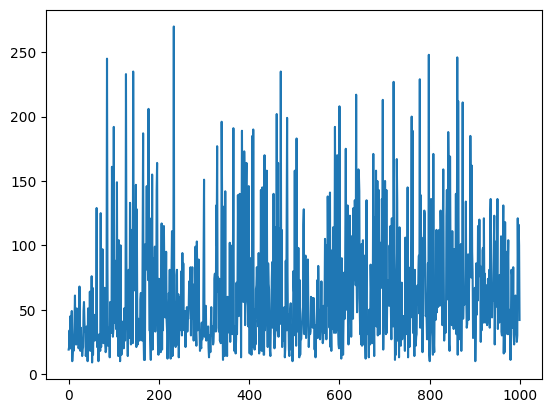

In [16]:
plt.plot(rewards)

From this graph, it is not possible to tell anything, because due to the nature of stochastic training process the length of training sessions varies greatly. To make more sense of this graph, we can calculate running average over series of experiments, let's say 100. This can be done conveniently using np.convolve:

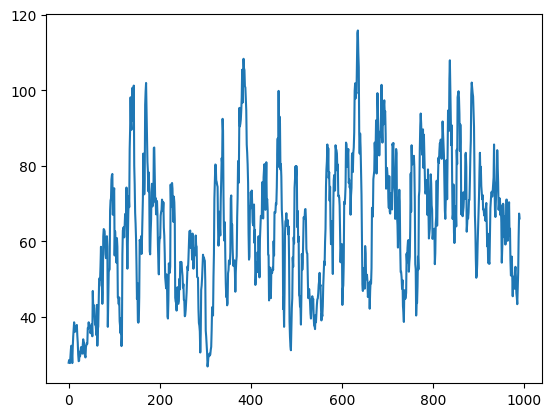

In [17]:
def running_average(x,window):
    return np.convolve(x,np.ones(window)/window,mode='valid')

plt.plot(running_average(rewards,10))

Varying Hyperparameters and Seeing the Result in Action
Now it would be interesting to actually see how the trained model behaves. Let's run the simulation, and we will be following the same action selection strategy as during training: sampling according to the probability distribution in Q-Table:


In [18]:
env = gym.make("CartPole-v1", render_mode = "human")
observation, info = env.reset()
terminated = False
truncated = False
while not terminated and not truncated:
    s = discretize(observation)
    v = probs(np.array(qvalues(s)))
    a = random.choices(actions,weights=v)[0]
    observation, reward, terminated, truncated, info = env.step(a)
    
env.close()

Saving result to an animated GIF
If you want to impress your friends, you may want to send them the animated GIF picture of the balancing pole. To do this, we can invoke env.render to produce an image frame, and then save those to animated GIF using PIL library:

In [19]:
from PIL import Image
env = gym.make("CartPole-v1", render_mode = "rgb_array")
observation, info = env.reset()
i=0
ims = []
terminated = False
truncated = False
while not terminated and not truncated:
   s = discretize(observation)
   img= env.render()
   ims.append(Image.fromarray(img))
   v = probs(np.array([Qbest.get((s,a),0) for a in actions]))
   a = random.choices(actions,weights=v)[0]
   observation, reward, terminated, truncated, info = env.step(a)
   i+=1
   
env.close()
ims[0].save('images/cartpole-balance.gif',save_all=True,append_images=ims[1::2],loop=0,duration=5)
print(i)

103


Extra practice. Used this to understand how the code works.


In [ ]:
env = gym.make("LunarLander-v2", render_mode="human")
observation, info = env.reset()

for _ in range(1000):
    action = env.action_space.sample()  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()

env.close()

In [22]:
env = gym.make("CartPole-v1", render_mode="human")
observation, info = env.reset()

for _ in range(100):
    action = env.action_space.sample()  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action)
    print(f"{observation} -> {reward}")

    if terminated or truncated:
        observation, info = env.reset()

env.close()

[ 0.02493078  0.24292998  0.01878529 -0.33427155] -> 1.0
[ 0.02978938  0.04754578  0.01209986 -0.03572442] -> 1.0
[ 0.0307403   0.24249214  0.01138537 -0.3245653 ] -> 1.0
[ 0.03559014  0.04720994  0.00489406 -0.02831375] -> 1.0
[ 0.03653434  0.24226137  0.00432779 -0.31944853] -> 1.0
[ 0.04137957  0.04707805 -0.00206118 -0.02540393] -> 1.0
[ 0.04232113 -0.14801428 -0.00256926  0.26662797] -> 1.0
[ 0.03936084 -0.34309947  0.0027633   0.5584994 ] -> 1.0
[ 0.03249885 -0.5382601   0.01393329  0.8520517 ] -> 1.0
[ 0.02173365 -0.7335692   0.03097432  1.1490831 ] -> 1.0
[ 0.00706227 -0.538865    0.05395598  0.86627185] -> 1.0
[-0.00371503 -0.3445172   0.07128142  0.59102976] -> 1.0
[-0.01060538 -0.15046181  0.08310202  0.3216249 ] -> 1.0
[-0.01361461 -0.3466628   0.08953451  0.63931465] -> 1.0
[-0.02054787 -0.54291147  0.10232081  0.95879656] -> 1.0
[-0.0314061  -0.73924917  0.12149674  1.2817925 ] -> 1.0
[-0.04619108 -0.54586613  0.14713259  1.0294886 ] -> 1.0
[-0.05710841 -0.7426069   0.167